In [58]:
import pandas as pd
import gzip
import json
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
archivo_comprimido = 'Json_comprimidos\steam_games.json.gz'
# Descomprimir y leer el primer archivo con gzip
with gzip.open(archivo_comprimido, 'rt', encoding='utf-8') as f:
    contenido_json = []
    for linea in f:
        contenido_json.append(json.loads(linea.strip()))

df_juegos = pd.DataFrame(contenido_json)
df_juegos.tail(3)

df_items = pd.read_json('dataframe_items_desanidados.json')


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\lucat\AppData\Local\Temp\ipykernel_4412\11900938.py:1: SyntaxWarning: invalid escape sequence '\s'
  archivo_comprimido = 'Json_comprimidos\steam_games.json.gz'


In [60]:
#Eliminamos las columnas que no nos sirven. 
# Para el subset hemos decidido quedarnos con los juegos mas jugados en playtime_forever. Son los juegos que los usuarios han preferido a o largo del tiempo. 

df_juegos = df_juegos.drop(columns=['publisher','title','url','reviews_url','early_access','developer','release_date'])
#Cambiamos el nombre de la columna para luego hacer JOIN
df_juegos.rename(columns={'id':'item_id'}, inplace=True)
df_juegos.isna().sum()

genres      91593
app_name    88312
tags        88473
specs       88980
price       89687
item_id     88312
dtype: int64

In [61]:
#Eliminamos todos los que tengan nulo en el item_id porque no nos sirven para el join ni tampooco para recomendaciones. 
df_juegos = df_juegos.dropna(subset='item_id')
#Lo pasamos a tipo entero para poder joinear. 
df_juegos['item_id'] = df_juegos['item_id'].astype(int)
df_juegos.isna().sum()

genres      3282
app_name       1
tags         162
specs        669
price       1377
item_id        0
dtype: int64

In [62]:
#Del df items nos vamos a quedar con los juegos mas jugados unicamente. 
# Agrupar por 'item_id' y sumar 'playtime_forever'
df_items = df_items[df_items['playtime_forever'].notnull()]  # Eliminar filas con valores nulos en 'playtime_forever'
df_mas_jugados = df_items.groupby('item_id')['playtime_forever'].sum().reset_index()
#Nos quedamos con los que tengan mas de 0 en jugado acumulado
df_mas_jugados = df_mas_jugados[df_mas_jugados['playtime_forever']>0]
# Ordenar el DataFrame por 'playtime_forever' en orden descendente
df_mas_jugados = df_mas_jugados.sort_values(by='playtime_forever', ascending=False)
df_juegos.isna().sum()

genres      3282
app_name       1
tags         162
specs        669
price       1377
item_id        0
dtype: int64

In [63]:
df_mas_jugados

,item_id,playtime_forever
23,730.0,785184267.0
163,4000.0,448366616.0
1673,105600.0,154974541.0
1543,72850.0,136678626.0
2403,230410.0,124027703.0
...,...,...
2101,215374.0,1.0
10141,472770.0,1.0
8114,402475.0,1.0
1855,205180.0,1.0


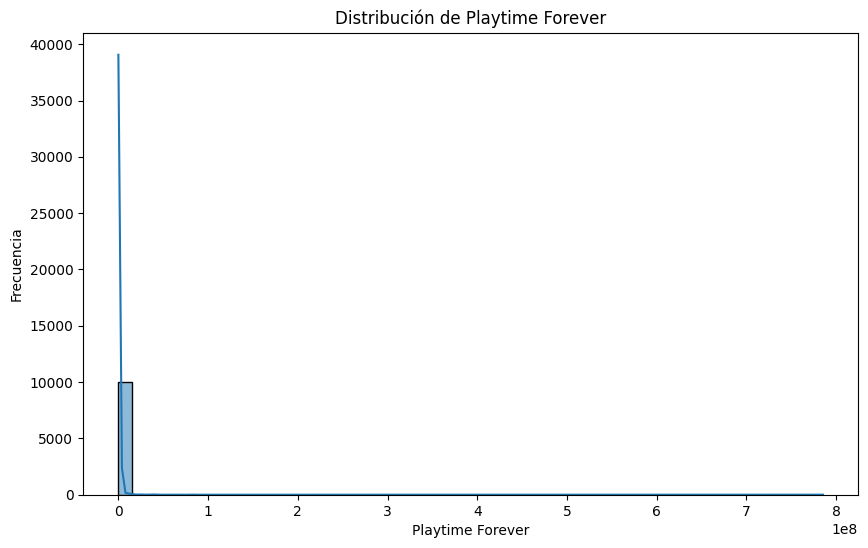

In [64]:
# Crear un gráfico de la distribución de playtime_forever
plt.figure(figsize=(10, 6))
sns.histplot(df_mas_jugados['playtime_forever'], bins=50, kde=True)
plt.title('Distribución de Playtime Forever')
plt.xlabel('Playtime Forever')
plt.ylabel('Frecuencia')
plt.show()

El gráfico que estamos viendo sugiere que la mayoría de los valores de playtime_forever son muy pequeños en comparación con algunos valores extremadamente grandes, lo que causa una escala no uniforme. Esto es típico de una distribución sesgada con valores atípicos (outliers). Vamos a modificar un poco los datos para volver a graficarlo. 

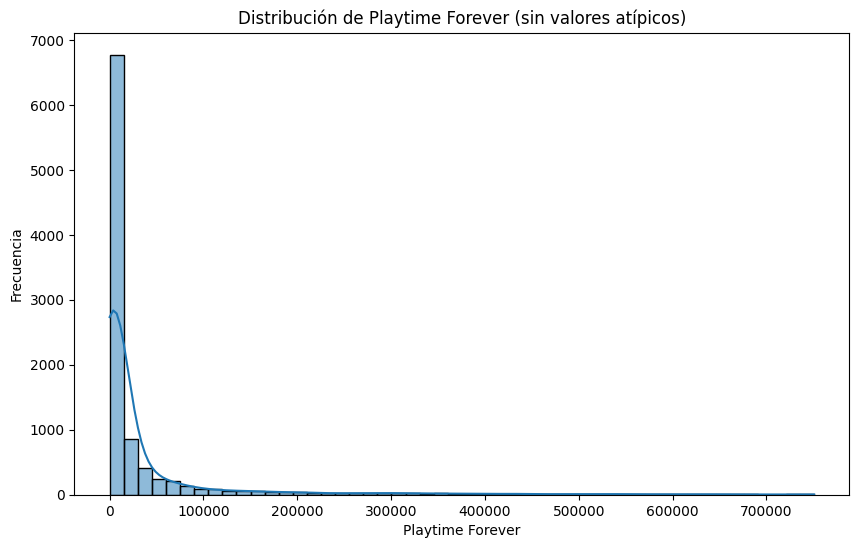

In [65]:
# Eliminar valores atípicos usando el percentil 95
percentil_95 = df_mas_jugados['playtime_forever'].quantile(0.95)
df_sin_outliers = df_mas_jugados[df_mas_jugados['playtime_forever'] <= percentil_95]
# Crear un gráfico de la distribución de playtime_forever (sin valores atípicos)
plt.figure(figsize=(10, 6))
sns.histplot(df_sin_outliers['playtime_forever'], bins=50, kde=True)
plt.title('Distribución de Playtime Forever (sin valores atípicos)')
plt.xlabel('Playtime Forever')
plt.ylabel('Frecuencia')
plt.show()

En este gráfico podemos observar que la gran mayoría de los juegos tienen muy poco tiempo de playtime histórico, pudiendo inferir que no tienen éxito con el usuario. Por lo tanto vamos a proceder a eliminarlos debido a que debemos reducir el Dataset para que nuestra funcion de recomendación pueda funcionar. 

In [66]:
#Al menos que tenga más de 1000 en acumulado de juego entre todos los usuarios. 
df_mas_jugados = df_mas_jugados[df_mas_jugados['playtime_forever']>1000]
#Sabemos que nuestra función en render no puede procesar más de 4500 registros aproximadamente. Por eso debemos chequear la longitud de nuestro dataset
df_mas_jugados.shape

(7057, 2)

In [67]:
#7000 sigue siendo muy alto, debemos reducirlo aún más 
df = df_mas_jugados[df_mas_jugados['playtime_forever']>7000]
df.shape

(4463, 2)

In [68]:
#Nos quedamos con 4463 registros, una cantidad manejable para nuestra función. 
df_juegos = pd.merge(df_juegos, df_mas_jugados,on='item_id',how='inner')

In [69]:
#Desanidamos las columnas con la información del juego. 
df_juegos['genres'] = df_juegos['genres'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
df_juegos['tags'] = df_juegos['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')
df_juegos['specs'] = df_juegos['specs'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')

In [70]:
#Escalamos el playtime_forever para ver si luego necesitamos usarlo como filtro de orden.
scaler = MinMaxScaler()

# Ajustar y transformar la columna 'playtime_forever'
df_juegos['puntaje'] = scaler.fit_transform(df_juegos[['playtime_forever']])
df_juegos

,genres,app_name,tags,specs,price,item_id,playtime_forever,puntaje
0,"Action, Indie, Racing",Carmageddon Max Pack,"Racing, Action, Classic, Indie, Gore, 1990's, ...","Single-player, Multi-player, Steam Trading Cards",9.99,282010,9319.0,0.000011
1,Action,Half-Life,"FPS, Classic, Action, Sci-fi, Singleplayer, Sh...","Single-player, Multi-player, Valve Anti-Cheat ...",9.99,70,2682852.0,0.003416
2,Strategy,Disciples II: Gallean's Return,"Turn-Based Strategy, Strategy, Classic, Atmosp...","Single-player, Multi-player, Co-op",6.99,1640,27397.0,0.000034
3,Strategy,Disciples II: Rise of the Elves,"Strategy, Turn-Based Strategy, Fantasy, Turn-B...","Single-player, Multi-player, Co-op",6.99,1630,21111.0,0.000026
4,"Action, Indie, RPG",The Ship: Murder Party,"Multiplayer, Indie, Action, First-Person, Stea...","Single-player, Multi-player, Steam Trading Car...",9.99,2400,1048156.0,0.001334
...,...,...,...,...,...,...,...,...
6119,"Action, Adventure",Mafia,"Action, Adventure, Violent, Story Rich, Classi...",Single-player,14.99,40990,45524.0,0.000057
6120,Action,Day of Defeat,"FPS, World War II, Multiplayer, Action, Shoote...","Multi-player, Valve Anti-Cheat enabled",4.99,30,758991.0,0.000965
6121,"Strategy, RPG, Indie",Geneforge 2,"RPG, Indie, Strategy, Turn-Based Combat, Isome...",Single-player,19.99,200980,3393.0,0.000003
6122,Action,Unreal Tournament 2004: Editor's Choice Edition,"FPS, Arena Shooter, Action, Classic, Multiplay...","Single-player, Multi-player, Steam Trading Cards",14.99,13230,349119.0,0.000443


In [71]:
df = df_juegos
# Concatenamos las especificaciones de los juegos para poder utilizarlo en la similitud del coseno. 
df['combined_features'] = df['genres'] + ' ' + df['tags'] + ' ' + df['specs']

In [72]:
#Eliminamos las columnas que no nos sirven más
df = df.drop(columns= ['tags','specs','genres','price','playtime_forever'])

In [73]:
df.to_parquet('df_consulta_final.parquet')